# [Basic regression: Predict fuel efficiency ]([https://www.tensorflow.org/tutorials/keras/regression])

This notebook uses the classic Auto MPG Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

In [1]:
!pip install -q seaborn

In [2]:
# to use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns

import tensorflow as tf 

from tensorflow import keras 
from tensorflow.keras import layers 

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.3.0


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# The Auto MPG dataset

In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

## Import it using pandas

In [6]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


# Clean the data

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
dataset = dataset.dropna()

Origin is a categorical column, not numeric, so we need convert that to a one-hote column

In [9]:
dataset['Origin'] = dataset['Origin'].map({1:'USA',2:'Europe',3:'Japan'})

In [10]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,Europe
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA
397,31.0,4,119.0,82.0,2720.0,19.4,82,USA


In [11]:
dataset = pd.get_dummies(dataset,prefix = '',prefix_sep = '')

In [12]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


# Split the data into train and test 

In [13]:
train_dataset = dataset.sample(frac = 0.8, random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

# Inspect the data

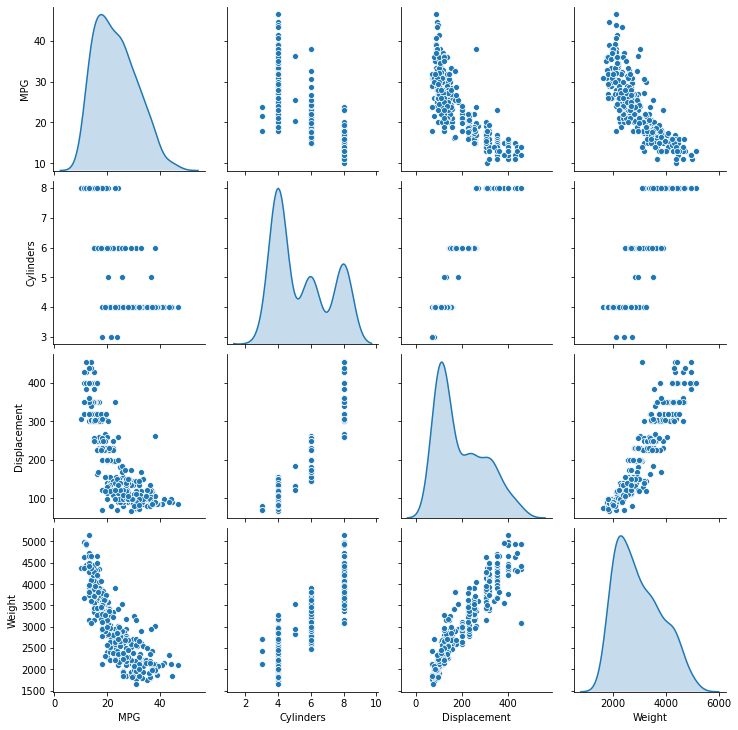

In [14]:
sns.pairplot(
    train_dataset[['MPG','Cylinders','Displacement','Weight']],diag_kind = 'kde'
)

In [15]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


#Split features from labels

In [16]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

# Normalize the data

In [17]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

In [18]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# The Model

In [19]:
model = keras.Sequential(
    [
     layers.Dense(64, activation = 'relu', input_shape = [len(train_dataset.keys())]),
     layers.Dense(64, activation = 'relu'),
     layers.Dense(1)
    ]
)

optimizer = tf.keras.optimizers.RMSprop(0.001) # learning_rate = 0.001
model.compile(
    loss = 'mse', # mean squared error
    optimizer = optimizer,
    metrics = ['mae','mse'], # mae = mean absolute error
)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(normed_train_data, train_labels,
                    epochs = 1000, validation_split = 0.2, verbose = 0,
                    callbacks = [tfdocs.modeling.EpochDots()]
)


Epoch: 0, loss:559.8588,  mae:22.3316,  mse:559.8588,  val_loss:548.7328,  val_mae:21.9979,  val_mse:548.7328,  
....................................................................................................
Epoch: 100, loss:5.8504,  mae:1.6779,  mse:5.8504,  val_loss:7.9762,  val_mae:2.1862,  val_mse:7.9762,  
....................................................................................................
Epoch: 200, loss:5.3506,  mae:1.6106,  mse:5.3506,  val_loss:8.1551,  val_mae:2.2434,  val_mse:8.1551,  
....................................................................................................
Epoch: 300, loss:5.0036,  mae:1.5194,  mse:5.0036,  val_loss:8.2209,  val_mae:2.2296,  val_mse:8.2209,  
....................................................................................................
Epoch: 400, loss:4.7203,  mae:1.4743,  mse:4.7203,  val_loss:8.2843,  val_mae:2.2023,  val_mse:8.2843,  
..............................................................

In [22]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.841928,1.071638,2.841928,9.331364,2.345978,9.331364,995
996,2.958287,1.093300,2.958287,9.101976,2.285602,9.101976,996
997,2.789865,1.058943,2.789865,9.877417,2.404675,9.877417,997
998,3.016625,1.143349,3.016625,8.768261,2.245428,8.768261,998
999,2.868334,1.035029,2.868334,9.374084,2.316292,9.374084,999


In [23]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

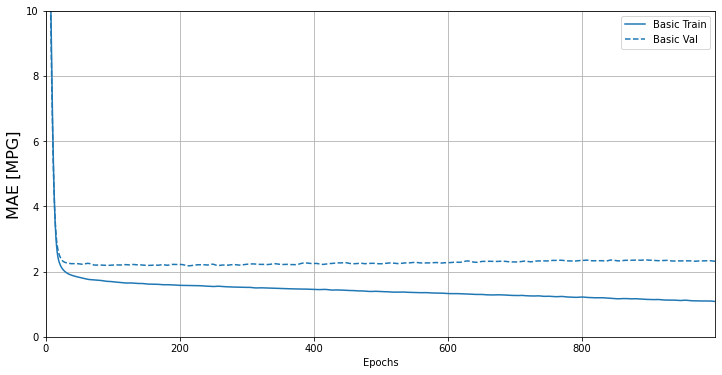

In [24]:
plt.figure(figsize=(12,6))
plotter.plot({'Basic':history},metric="mae")
plt.ylim([0,10])
plt.ylabel('MAE [MPG]',fontsize=16)

Text(0, 0.5, 'MSE [MPG^2]')

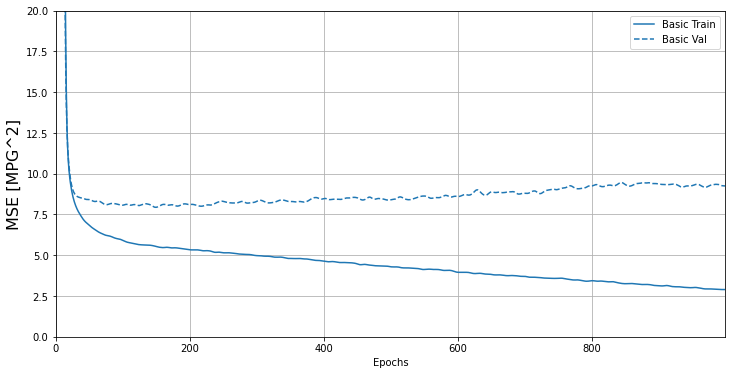

In [25]:
plt.figure(figsize=(12,6))
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]',fontsize = 16)

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the model.fit call to automatically stop training when the validation score doesn't improve. We'll use an EarlyStopping callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

In [26]:
model2 = keras.Sequential(
    [
     layers.Dense(64, activation = 'relu', input_shape = [len(train_dataset.keys())]),
     layers.Dense(64, activation = 'relu'),
     layers.Dense(1)
    ]
)

optimizer = tf.keras.optimizers.RMSprop(0.001) # learning_rate = 0.001

model2.compile(
    loss = 'mse', # mean squared error
    optimizer = optimizer,
    metrics = ['mae','mse'], # mae = mean absolute error
)

In [27]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


In [28]:
history2 = model2.fit(normed_train_data, train_labels,
                    epochs = 1000, validation_split = 0.2, verbose = 0,
                    callbacks = [tfdocs.modeling.EpochDots()]
)


Epoch: 0, loss:555.8571,  mae:22.3049,  mse:555.8571,  val_loss:542.4009,  val_mae:22.0001,  val_mse:542.4009,  
....................................................................................................
Epoch: 100, loss:6.0230,  mae:1.7342,  mse:6.0230,  val_loss:8.0510,  val_mae:2.1839,  val_mse:8.0510,  
....................................................................................................
Epoch: 200, loss:5.1080,  mae:1.5360,  mse:5.1080,  val_loss:8.3948,  val_mae:2.2814,  val_mse:8.3948,  
....................................................................................................
Epoch: 300, loss:4.7498,  mae:1.4531,  mse:4.7498,  val_loss:8.3793,  val_mae:2.2784,  val_mse:8.3793,  
....................................................................................................
Epoch: 400, loss:4.1151,  mae:1.3376,  mse:4.1151,  val_loss:8.6566,  val_mae:2.2326,  val_mse:8.6566,  
..............................................................

Text(0, 0.5, 'MAE [MPG]')

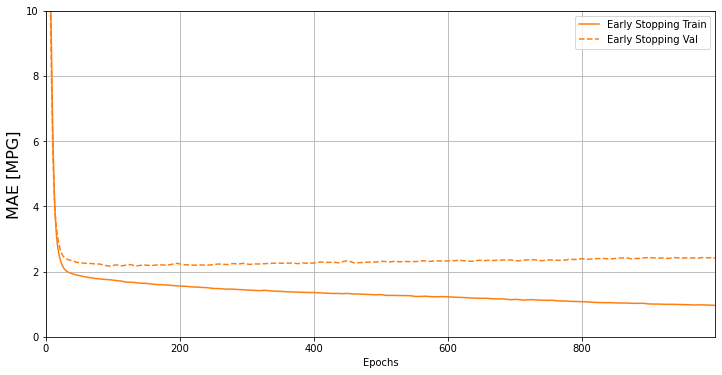

In [29]:
plt.figure(figsize=(12,6))
plotter.plot({'Early Stopping':history2},metric="mae")
plt.ylim([0,10])
plt.ylabel('MAE [MPG]',fontsize=16)

# Make predictions

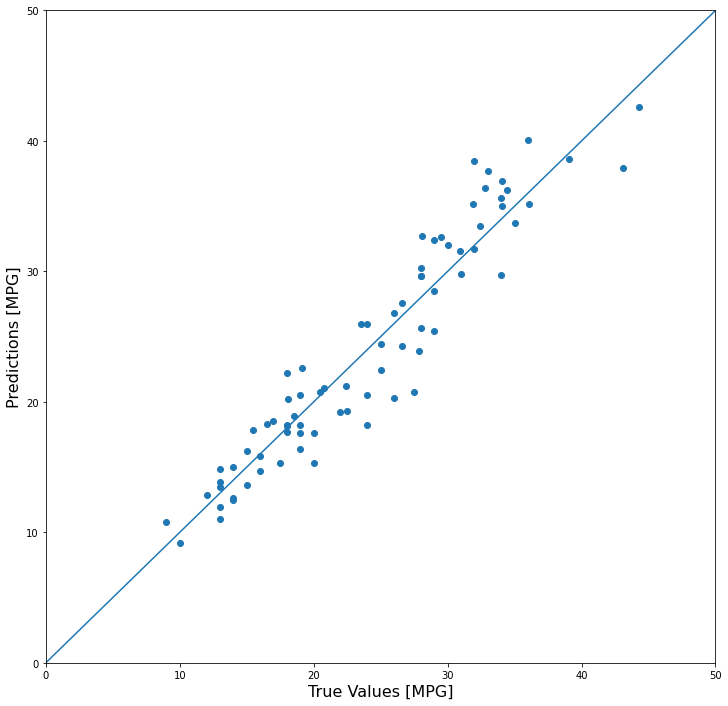

In [30]:
test_predictions = model2.predict(normed_test_data).flatten()

plt.figure(figsize=(12,12))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]', fontsize = 16)
plt.ylabel('Predictions [MPG]', fontsize = 16)
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)